In [1]:
import torch
import Trainer
from network import NFM
import torch.utils.data as Data
from Utils.criteo_loader import getTestData, getTrainData

nfm_config = \
{
    'n_class':9,
    'linear_hidden1':2000,
    #'linear_hidden':100,#线性模型输出层（隐层个数）
    #'embed_input_dim':1001,#embed输入维度
    #'embed_dim': 100, # 用于控制稀疏特征经过Embedding层后的稠密特征大小，embed输出维度
    #'dnn_hidden_units': [100,11],#MLP隐层和输出层
    
    'dnn_hidden_units':[100,9],#MLP隐层
    'num_sparse_features_cols':10477,#the number of the gene columns
    'num_dense_features': 0,#dense features number
    'bi_dropout': 0.5,#Bi-Interaction 的dropout
    'num_epoch': 500,#训练epoch次数
    'batch_size': 16,#batch_size
    'lr': 1e-3,
    'l2_regularization': 1e-4,
    'device_id': 0,
    'use_cuda': False,
    'epoch':1000,
    
    #'train_file': '../Data/criteo/processed_data/train_set.csv',
    #'fea_file': '../Data/criteo/processed_data/fea_col.npy',
    #'validate_file': '../Data/criteo/processed_data/val_set.csv',
    #'test_file': '../Data/criteo/processed_data/test_set.csv',
    #'model_name': '../TrainedModels/NFM.model'
    #'train_file':'data/xiaoqiu_gene_5000/train/final_5000_encode_100x.csv',
    #'train_data':'dataset/qiuguan/encode/encode_1000/train/train_encode_data_1000_new.csv',
    #'train_label':'dataset/qiuguan/non_code/train/train_label.csv',
    #'guan_test_data':'dataset/qiuguan/non_code/guan_test/guan_test_data.csv',
    #'guan_test_label':'dataset/qiuguan/non_code/guan_test/guan_test_label.csv',
    #'test_data':'dataset/qiuguan/encode/encode_1000/test/test_encode_data_1000_new.csv',
    #'test_label':'dataset/qiuguan/non_code/test/test_labels.csv',
    #'title':'dataset/xiaoguan/RF/RF_for_train/train_class_9/test/test_data.csv',
    
    #'all':''
    #'title':'data/xiaoqiu_gene_5000/train/gene_5000_gene_name.csv',
    #'all':'data/xiaoqiu_gene_5000/train/gene_5000_label_name.csv'
}

#model definition
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model = MLP().cuda()
print(model)


import os
import time
import argparse
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import torch.nn.functional as F  # 激励函数的库
#import network
import config
import evaluate
import data_utils
#import Trainer



def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output


def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output

class KZDatasetTest(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, csv_path):
    
        self.data_info = self.get_data_info(csv_path)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',',header=None)
        df=df.iloc[1:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
import torch
import torch.nn as nn
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import ast
import torchvision


        

class KZDataset(Dataset):
    def __init__(self, csv_path, K,n_class,ki=0, typ='train', transform=None, rand=False):
       
        self.all_data_info = self.get_data_info(csv_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',',header=None)
        df=df.iloc[1:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
            
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import sys 
#import network
import config
import evaluate
import data_utils
import Trainer
import torchmetrics

from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import sys 
#import network
import config
import evaluate
import data_utils
import Trainer
import torchmetrics


def train_epoch(model,train_loader,batch_size,optimizer,loss_func):
    BATCH_SIZE=batch_size
    total = 0
    correct=0
    total_loss=0
    #
    model.train()
    total_train_accuracy=0  
    for batch_idx, (x, labels) in enumerate(train_loader):
            
        labels = Variable(labels)
        x = Variable(x)
            
            
        x=torch.tensor(x,dtype=torch.float)
        labels=torch.tensor(labels,dtype=torch.float)
        x, labels = x.cuda(), labels.cuda()
        labels_int=labels=torch.max(labels,1)[1]
            
            
        optimizer.zero_grad()
        y_predict = model(x)
            
        loss = loss_func(y_predict, labels)
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
           

        total_loss += loss
            
            
            
        batch_train_acc=torchmetrics.functional.accuracy(y_predict,labels_int)
        total_train_accuracy+=batch_train_acc
            
    total_train_accuracy/=(batch_idx+1)
    print('total_train_accuracy:',total_train_accuracy)
    print("Training Epoch: %d, total loss: %f" % (epoch_id, total_loss))
    return total_loss,total_train_accuracy

def val_epoch(model,test_loader,batch_size,optimizer): 
    batch_size_num=0
    total_test_acc=0
    model.eval()
    for i , (inputs , targets) in enumerate(test_loader):   
            print("test")
            
            inputs = Variable(inputs)   
            targets = Variable(targets)     
           
            inputs=torch.tensor(inputs ,dtype=torch.float)   
            targets=torch.tensor(targets ,dtype=torch.float)   
            inputs , targets = inputs.cuda(),  targets.cuda()   
            yhat = model(inputs)  
            
            
            
            targets=torch.max(targets,1)[1]
            
            
            
            batch_test_acc=torchmetrics.functional.accuracy(yhat,targets)
            
            total_test_acc+=batch_test_acc
            
            batch_size_num=i
    total_test_acc/=(batch_size_num+1)
        ###print('total_test_accuracy:',total_test_acc/(batch_size+1))
    print('total_test_accuracy:',total_test_acc)
        
                    
                    
            
            
    
        
   
    
    return total_test_acc


import numpy as np
import math
import matplotlib.pyplot as plt

def plotLoss(loss,epoch):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    x=[i for i in range(epoch)]
    #acc_train=acc_train.cpu()
    #acc_test=acc_test.cpu()
    plt.plot(x, loss, 'r-', mec='k', label='Logistic Loss', lw=2)
    #plt.plot(x,acc_train,'b-',mec='k',label='accuracy Train',lw=2)
    #plt.plot(x,acc_test,'g-',mec='k',label='accuracy Test',lw=2)
    #plt.plot(x, y_01, 'g-', mec='k', label='0/1 Loss', lw=2)
    #plt.plot(x, y_hinge, 'b-',mec='k', label='Hinge Loss', lw=2)
    #plt.plot(x, boost, 'm--',mec='k', label='Adaboost Loss',lw=2)
    plt.grid(True, ls='--')
    plt.legend(loc='upper right')
    plt.title('损失函数')
    plt.show()
 


MLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


/home/zhengfang/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249

277 3301
277 3301


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:337: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total_train_accuracy: tensor(0.2583, device='cuda:0')
Training Epoch: 0, total loss: 31.909061
total_train_accuracy: tensor(0.5000, device='cuda:0')
Training Epoch: 1, total loss: 30.499995
total_train_accuracy: tensor(0.6083, device='cuda:0')
Training Epoch: 2, total loss: 29.459722
total_train_accuracy: tensor(0.6458, device='cuda:0')
Training Epoch: 3, total loss: 29.210747
total_train_accuracy: tensor(0.7042, device='cuda:0')
Training Epoch: 4, total loss: 28.506797
total_train_accuracy: tensor(0.7750, device='cuda:0')
Training Epoch: 5, total loss: 28.010685
total_train_accuracy: tensor(0.7958, device='cuda:0')
Training Epoch: 6, total loss: 27.673227
total_train_accuracy: tensor(0.7833, device='cuda:0')
Training Epoch: 7, total loss: 27.435857
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 8, total loss: 27.052990
total_train_accuracy: tensor(0.8958, device='cuda:0')
Training Epoch: 9, total loss: 26.512239
total_train_accuracy: tensor(0.9042, device='cuda:

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 87, total loss: 22.750495
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 88, total loss: 22.940227
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 89, total loss: 23.250662
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 90, total loss: 22.837940
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 91, total loss: 22.751101
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 92, total loss: 22.993857
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 22.941081
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 94, total loss: 22.908321
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 95, total loss: 22.812052
total_train_accuracy: tensor(0.9292, device='cuda:0')
Training Epoch: 96, total loss: 23.215805
total_train_accuracy: tensor(0.9875, dev

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


the  0  epoch ends


/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20989 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/zhengfang/anaconda3/envs/new_pytorch/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)


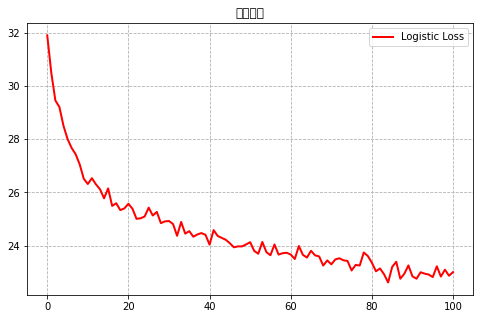

/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:375: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test
total_test_accuracy: tensor(0.8750, device='cuda:0')
acc_test_each_k: tensor(0.8750, device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 0, total loss: 23.493879
total_train_accuracy: tensor(0.9250, device='cuda:0')
Training Epoch: 1, total loss: 23.158301
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 2, total loss: 22.883405
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 3, total loss: 22.727740
total_train_accuracy: tensor(0.9500, device='cuda:0')
Training Epoch: 4, total loss: 23.043217
total_train_accuracy: tensor(0.9625, device='cuda:0')
Training Epoch: 5, total loss: 22.801950
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 6, total loss: 23.123052
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 7, total loss: 22.349391
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 8, total loss: 22.824193
total_train_accuracy

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 86, total loss: 21.724567
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 87, total loss: 21.854516
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 88, total loss: 21.843516
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 89, total loss: 21.586511
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 90, total loss: 21.698144
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 91, total loss: 21.707910
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 92, total loss: 22.208426
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 93, total loss: 21.993317
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 94, total loss: 21.767485
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 95, total loss: 21.577014
total_train_accuracy: tensor(0.9958, dev

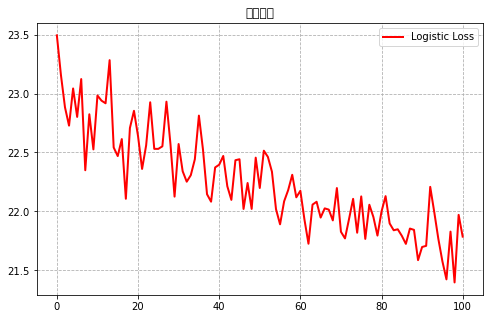

test
total_test_accuracy: tensor(0.9375, device='cuda:0')
acc_test_each_k: tensor(0.9375, device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 0, total loss: 21.870834
total_train_accuracy: tensor(0.9458, device='cuda:0')
Training Epoch: 1, total loss: 22.014989
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 2, total loss: 21.831987
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 3, total loss: 21.772435
total_train_accuracy: tensor(0.9542, device='cuda:0')
Training Epoch: 4, total loss: 21.987972
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 5, total loss: 21.736083
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 6, total loss: 21.865724
total_train_accuracy: tensor(0.9417, device='cuda:0')
Training Epoch: 7, total loss: 22.119065
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 8, total loss: 21.532336
total_train_accuracy

total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 87, total loss: 21.434136
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 88, total loss: 21.370765
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 89, total loss: 21.416344
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 90, total loss: 21.348857
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 91, total loss: 21.207026
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 92, total loss: 21.203253
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 93, total loss: 21.602283
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 94, total loss: 21.459523
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 95, total loss: 21.456224
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 96, total loss: 21.425076
total_train_accuracy: tensor(0.9958, device=

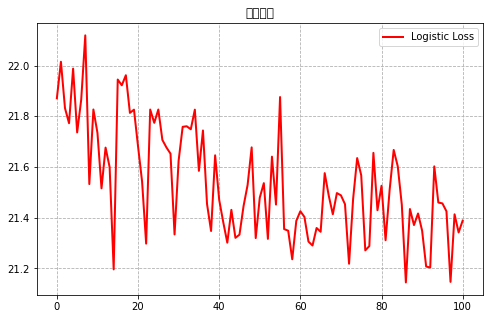

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 0, total loss: 21.711789
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 1, total loss: 21.417420
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 2, total loss: 21.197936
total_train_accuracy: tensor(0.9667, device='cuda:0')
Training Epoch: 3, total loss: 21.583377
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 4, total loss: 21.403608
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 5, total loss: 21.439241
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 6, total loss: 21.215112
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 7, total loss: 21.260934
total_train_accuracy: tensor(0.9583, device='cuda:0')
Training Epoch: 8, total loss: 21.793201
total_train_accuracy: tensor(0.9

total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 87, total loss: 21.342776
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 88, total loss: 21.372957
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 89, total loss: 21.254262
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 90, total loss: 21.264782
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 91, total loss: 21.403335
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 92, total loss: 21.161304
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 93, total loss: 21.311841
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 94, total loss: 21.255810
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 95, total loss: 21.161644
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 96, total loss: 21.042393
total_train_accuracy: tensor(1., device=

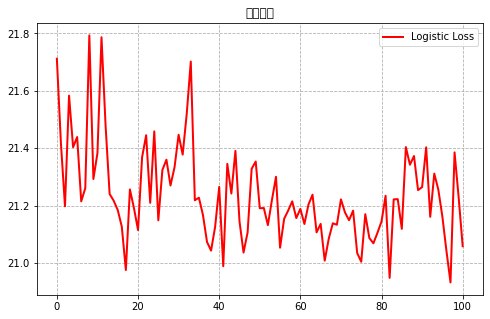

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 0, total loss: 21.131659
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 1, total loss: 20.925050
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 2, total loss: 21.028995
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 3, total loss: 21.251425
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 4, total loss: 21.033208
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 5, total loss: 21.137597
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 6, total loss: 21.249659
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 7, total loss: 21.116674
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 8, total loss: 21.268309
total_train_accuracy: tensor(0.9

total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 87, total loss: 21.301879
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 88, total loss: 21.167230
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 89, total loss: 21.031786
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 90, total loss: 21.061981
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 91, total loss: 21.152431
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 92, total loss: 21.010928
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 93, total loss: 21.181842
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 94, total loss: 20.927911
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 95, total loss: 21.008157
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 96, total loss: 20.966065
total_train_accuracy: tensor(0.9875, device='cud

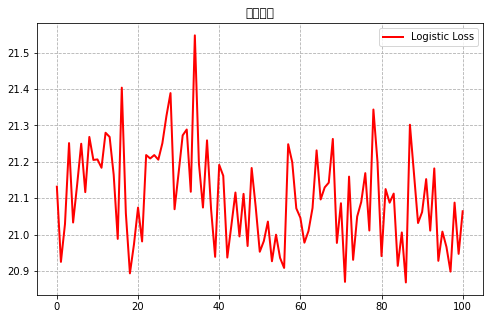

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 0, total loss: 21.038305
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 1, total loss: 20.888362
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 2, total loss: 20.889591
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 3, total loss: 21.064427
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 4, total loss: 21.122572
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 5, total loss: 20.972721
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 6, total loss: 21.095146
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 7, total loss: 21.007792
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 8, total loss: 21.036060
total_train_accuracy: tensor(0.9

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 87, total loss: 21.213321
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 88, total loss: 20.990055
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 89, total loss: 21.092488
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 90, total loss: 21.072230
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 91, total loss: 21.075285
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 92, total loss: 21.017105
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 93, total loss: 20.911797
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 94, total loss: 20.831739
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 95, total loss: 20.904421
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 96, total loss: 20.981691
total_train_accuracy: tensor(0.9917, device=

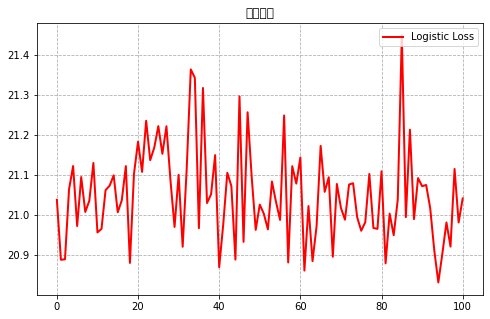

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 0, total loss: 21.236118
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 1, total loss: 20.900548
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 2, total loss: 21.283936
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 3, total loss: 21.142166
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 4, total loss: 21.034767
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 5, total loss: 21.009455
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 6, total loss: 20.804061
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 7, total loss: 20.908966
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 8, total loss: 20.999573
total_train_accuracy: tensor(0.9

total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 87, total loss: 21.062407
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 88, total loss: 20.857799
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 89, total loss: 20.967113
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 90, total loss: 20.919551
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 91, total loss: 20.909506
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 92, total loss: 20.963059
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 93, total loss: 20.839869
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 94, total loss: 21.093248
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 95, total loss: 20.917670
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 96, total loss: 20.992493
total_train_accuracy: tensor(0.9667, device=

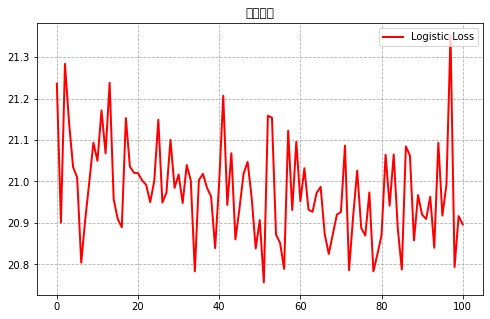

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 0, total loss: 21.228907
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 1, total loss: 20.905030
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 2, total loss: 20.868122
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 3, total loss: 20.860851
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 4, total loss: 21.131940
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 5, total loss: 20.894627
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 6, total loss: 20.836433
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 7, total loss: 20.836573
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 8, total loss: 21.005844
total_train_accuracy: tensor(0.9833,

total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 87, total loss: 21.225942
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 88, total loss: 21.023959
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 89, total loss: 20.945310
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 90, total loss: 21.019680
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 91, total loss: 20.813560
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 92, total loss: 21.144479
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 93, total loss: 20.916068
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 94, total loss: 20.895280
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 95, total loss: 20.975052
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 96, total loss: 20.885467
total_train_accuracy: tensor(0.9875, device='cud

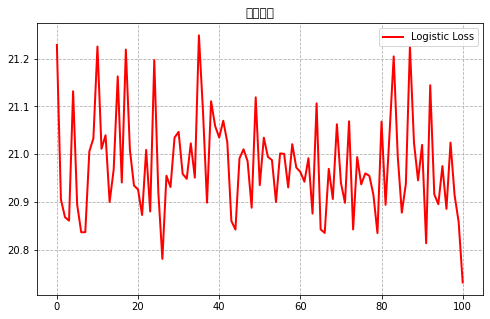

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 0, total loss: 20.793564
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 1, total loss: 20.997645
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 2, total loss: 21.018914
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 3, total loss: 20.982796
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 4, total loss: 20.983523
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 5, total loss: 20.866054
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 6, total loss: 20.857669
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 7, total loss: 20.927268
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 8, total loss: 21.069642
total_train_accuracy: tensor(0.9917,

total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 87, total loss: 20.924448
total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 88, total loss: 21.176304
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 89, total loss: 21.043468
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 90, total loss: 20.770463
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 91, total loss: 20.859875
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 92, total loss: 20.787025
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 93, total loss: 20.973883
total_train_accuracy: tensor(0.9750, device='cuda:0')
Training Epoch: 94, total loss: 21.178988
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 95, total loss: 20.984120
total_train_accuracy: tensor(0.9833, device='cuda:0')
Training Epoch: 96, total loss: 20.994385
total_train_accuracy: tensor(0.9833, device='cuda:0'

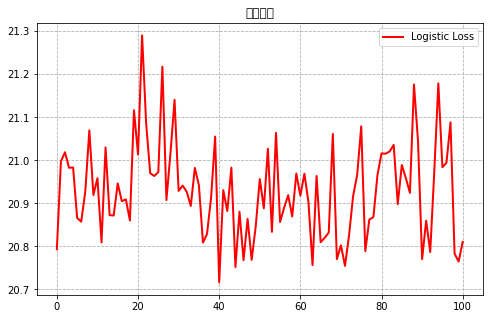

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
277 3301
277 3301
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 0, total loss: 21.033194
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 1, total loss: 20.851780
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 2, total loss: 20.955655
total_train_accuracy: tensor(0.9708, device='cuda:0')
Training Epoch: 3, total loss: 21.163313
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 4, total loss: 20.864948
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 5, total loss: 20.751904
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 6, total loss: 20.791896
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 7, total loss: 20.798743
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 8, total loss: 20.884974
total_train_accuracy: tensor(0.9958, dev

total_train_accuracy: tensor(0.9792, device='cuda:0')
Training Epoch: 85, total loss: 21.019760
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 86, total loss: 20.990486
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 87, total loss: 21.088882
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 88, total loss: 20.849278
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 89, total loss: 20.925020
total_train_accuracy: tensor(0.9875, device='cuda:0')
Training Epoch: 90, total loss: 20.866842
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 91, total loss: 20.930409
total_train_accuracy: tensor(1., device='cuda:0')
Training Epoch: 92, total loss: 20.753621
total_train_accuracy: tensor(0.9917, device='cuda:0')
Training Epoch: 93, total loss: 20.839113
total_train_accuracy: tensor(0.9958, device='cuda:0')
Training Epoch: 94, total loss: 20.846708
total_train_accuracy: tensor(0.9875, device='cud

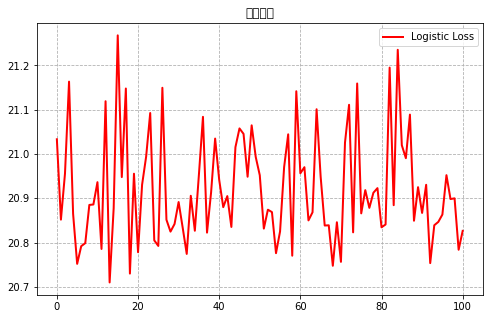

test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
[tensor(0.8750, device='cuda:0'), tensor(0.9375, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
[array(0.875, dtype=float32), array(0.9375, dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]
acc_test_metrics: 0.98125


In [2]:
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu/train_val_info.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu/train_val_info.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='dataset/qiuguan/origin_800/xiaoqiu/MLP_non_encode/'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)

MLP(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
70 3301
f1_score:  %.4f 0.9008980785296576
accuracy_score: 0.8714285714285714
recall_score: 0.8938993105659772
pre_recall: 0.9208333333333333
n_classes: 9


/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/zhengfang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

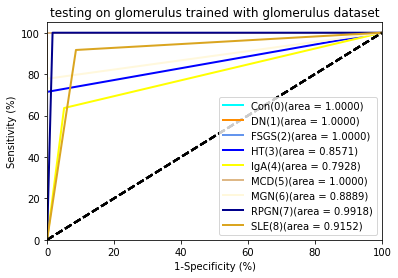

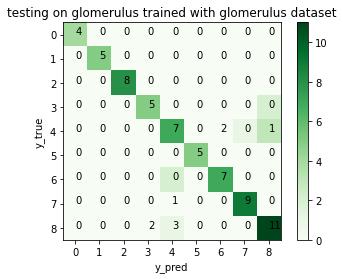

In [3]:
import torch

#功能：加载保存到path中的各层参数到神经网络

path='dataset/qiuguan/origin_800/xiaoqiu/MLP_non_encode/MLP610.pkl'

#nfm=NFM(nfm_config)
mlp=MLP()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu/test_info.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    plt.title('testing on glomerulus trained with glomerulus dataset') 
      

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 



#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('testing on glomerulus trained with glomerulus dataset')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()